In [1]:
# the building we want to run
building_id = 2
# Price of the panel
price = 106
# this will create a folder which will save the files
iteration = 35
# optimization method
# Currently implemented are: rbf-net, rbf-cost, ga-50, ga-20
opt_method = "rbf-cost"
# Number of evaluations:
number_of_opt_evaluations = 100
# number of run
run_i=2
# Some cluster solution
base_path=""

In [2]:
# Parameters
opt_method = "rbf-net"
number_of_opt_evaluations = 100
run_i = 2
iteration = 38
building_id = 2
price = 106


In [3]:
# Important file names 
# This is where the optimal solution or final population of solutions is provided
ga_file = "panel_{}_{}_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)
# here we store every run that optmizer runs
ga_proc = "panel_{}_{}_archive_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)
# Here we combine the optimal solution with the addition information that we are interested in.
ga_fina = "panel_{}_{}_processed_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)

In [4]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = base_path+'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = base_path+'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)
ga_file=ga_output_dir+ga_file
ga_proc=ga_output_dir+ga_proc
ga_fina=ga_output_dir+ga_fina



# Weather file
epw_file   = base_path+'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = base_path+'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [5]:
########### OUTPUT FILES ###############
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# EnergyPlus
output_dir = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
error_dir  = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
ensure_dir(output_dir)

# EHUB
ehub_dir   = base_path+'ehub/output_ehub_excel/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = base_path+"rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106


In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML
ep_path="/home/theochri/projects/def-revins/theochri/EnergyPlus/"

# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [8]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir,
                                   epw_file=epw_file, err_dir=error_dir,ep_path=ep_path)

/home/theochri/projects/def-revins/theochri/EnergyPlus/


## the North Axis
The north axis gets grabbed automatically from the idf.

In [9]:
pvbuilding.North_Axis

0.0

In [10]:
pvbuilding.Building_Information


Building,
    Ref Bldg Small Office New2004_v1.3_5.0,    !- Name
    0.0,                      !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [11]:
# Determine the hourly electricity use
pvbuilding.run_ep(ep_path=ep_path)

EnergyPlus is found in the path: /home/theochri/projects/def-revins/theochri/EnergyPlus/


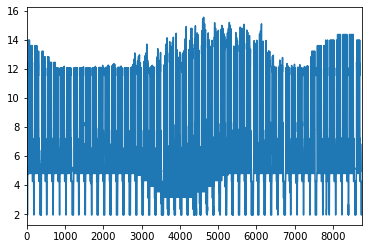

In [12]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [13]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 2,059.63
14.35220436334519


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [14]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 599 m2
Roof area is up 29 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [15]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.0165891647338867 sec


ERROR:root:Finished Generation of Irradiance


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.009296178817749 sec


ERROR:root:Finished Generation of Irradiance


0.0


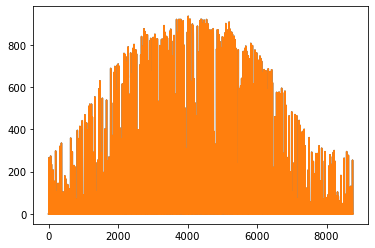

In [16]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)
Loading the model
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8951480388641357 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.906949758529663 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.918062686920166 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [307.537, 0.0, 0.0]


ERROR:ga_logger:Cost: 3187.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,188 per year


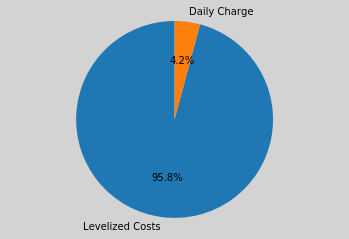

Total roof area of the  building: 599 m2
Total roof area used 473 m2
Percentage: 79.0%


In [17]:
from pv_model import pvModel
# this was the optimal solution
pan_vals = (155,175,260,26,36,36,0.65,0.7,0.9)
gcr=(0.65,0.7,0.9)
print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.

default_settings = {
                    'name': 'glpk-cluster',
                    'solver_path': '/home/theochri/ENV/bin/glpsol',
                    'options': {
                                'mipgap': 0.05,
                               },
                    }
# preload the excel
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels,
                           factor_multiplier=3,
                           solver_settings=default_settings)
my_model.eval_model(pan_vals,106,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [18]:
my_model.energyIm

61845.7

In [19]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    0.0
dtype: float64

In [20]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr         4805.72
Aug         5680.08
Dec         5274.31
Feb         4713.95
Jan         5340.70
Jul         5200.48
Jun         5124.65
Mar         5319.26
May         5015.79
Nov         5153.19
Oct         5154.70
Sep         5062.88
monthly_import    61845.71
dtype: float64
61845.7
     monthly_export
Apr         6899.34
Aug         8061.75
Dec         1351.01
Feb         2744.22
Jan         1541.01
Jul         9311.54
Jun         7990.47
Mar         4415.47
May         8175.98
Nov         1793.90
Oct         3229.92
Sep         6330.97
monthly_export    61845.58
dtype: float64
61845.6
133.042


In [21]:
my_model.solveResults['solution']['daily_charge_c']

133.042

In [22]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng             0
Grid                 1
Invertor             1
PV0                  1
PV1                  0
PV2                  0

In [23]:
my_model.solveResults['solution']['any_above_35']

0

In [24]:
my_model.solveResults['solution']['a150_or_a550']

0

# (D) GA - Optimize the model

In [25]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

In [26]:
# preload the excel
from pyehub.excel_to_request_format import convert

request_format = convert(excel_file=ehub_file)

In [27]:
import logging
lrun       = logging.getLogger('Runs_logger')
hdlrun       = logging.FileHandler('runs_logger.txt')
formatterrun  = logging.Formatter('%(asctime)s %(message)s')
hdlrun.setFormatter(formatterrun)
lrun.addHandler(hdlrun) 
lrun.setLevel(logging.ERROR)

In [28]:
import time
t1=time.time()

pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                         range_tilt=range_tilt,
                         range_gcr=range_gcr,
                         pvpanel=pvpanel,
                         price=price,
                         store_file=ga_file,
                         ehub_request=request_format,
                         res_file=res_file,
                         pvbuilding=pvbuilding,
                         roof_area_per_unit_capacity=roof_area_per_unit_capacity,
                         ga_proc=ga_proc,
                         solver_settings=default_settings)



ERROR:optimizer_logger:Found the solver set


/home/theochri/paper_pusher/lib/python3.6/site-packages/besos/evaluator.py:395: FutureWarning: EvaluatorSR has been renamed as EvaluatorGeneric with same functionaility. EvaluatorSR will be removed in a future release.
  warn(msg, FutureWarning)
ERROR:optimizer_logger:The number of evaluations is 100


[90.  90.  90.   1.   1.   1.   0.2  0.2  0.2] [265.  265.  265.   56.   56.   56.    0.9   0.9   0.9] ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R']


ERROR:ga_logger:panel values: (173.6358678988272, 154.2477681293841, 141.28289943244576, 42.634964899805894, 11.915204446457192, 32.433624589155826, 0.8976704103906306, 0.5407164426159418, 0.4737544298979539)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 174
                                           a tilt of 42.6
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.052312135696411 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 154
                                           a tilt of 11.9
                                           and a gcr of 0.541


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.881032705307007 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 141
                                           a tilt of 32.4
                                           and a gcr of 0.474


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.911252021789551 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 215.468, 94.8812]


ERROR:ga_logger:Cost: 3215.51


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


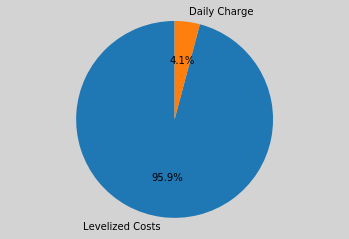

ERROR:ga_logger:panel values: (159.39354458291274, 236.91832065482936, 257.49580313310526, 52.15438781816305, 45.81885993999345, 46.44186748641727, 0.6245095208049042, 0.8269706191205983, 0.5479862851484307)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 159
                                           a tilt of 52.2
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.902683734893799 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 237
                                           a tilt of 45.8
                                           and a gcr of 0.827


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9051380157470703 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 257
                                           a tilt of 46.4
                                           and a gcr of 0.548


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9050610065460205 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [329.241, 0.0, 0.0]


ERROR:ga_logger:Cost: 3403.14


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


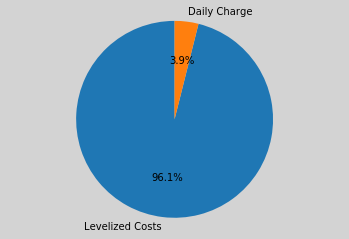

ERROR:ga_logger:panel values: (228.1578469945302, 99.96007990039456, 211.35780620698023, 32.40525862534277, 41.38985674089814, 41.0463882372238, 0.2077557971511908, 0.42237974568032727, 0.6796959258422313)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 228
                                           a tilt of 32.4
                                           and a gcr of 0.208


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.143216371536255 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 41.4
                                           and a gcr of 0.422


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8966591358184814 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 211
                                           a tilt of 41.0
                                           and a gcr of 0.680


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.903339147567749 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [36.321, 0.0, 288.148]


ERROR:ga_logger:Cost: 3355.75


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


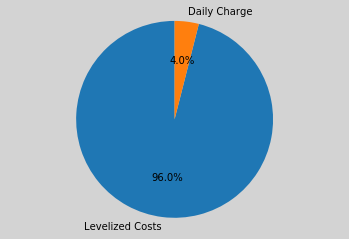

ERROR:ga_logger:panel values: (233.86527798448026, 214.22014926756623, 167.18869524666997, 3.949042626319947, 31.934838049590006, 15.132883385756465, 0.5843776822480665, 0.3364960361304743, 0.28859501409591815)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 234
                                           a tilt of 3.9
                                           and a gcr of 0.584


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8795101642608643 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 214
                                           a tilt of 31.9
                                           and a gcr of 0.336


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.281902313232422 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 167
                                           a tilt of 15.1
                                           and a gcr of 0.289


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8841724395751953 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [297.944, 29.9192, 0.0]


ERROR:ga_logger:Cost: 3389.46


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


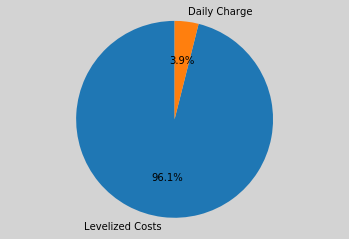

ERROR:ga_logger:panel values: (90.90487502609123, 167.1450199664713, 106.57982480585189, 15.420707879340696, 19.96809697727212, 8.4576486005348, 0.3900649878615676, 0.7259543011390175, 0.7929965478762389)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 15.4
                                           and a gcr of 0.390


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9524896144866943 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 167
                                           a tilt of 20.0
                                           and a gcr of 0.726


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8933093547821045 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 107
                                           a tilt of 8.5
                                           and a gcr of 0.793


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9161062240600586 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 307.961, 0.0]


ERROR:ga_logger:Cost: 3191.79


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


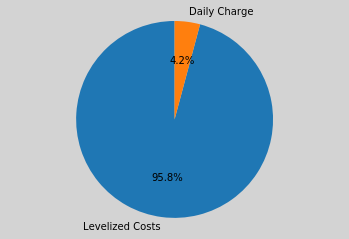

ERROR:ga_logger:panel values: (177.5, 177.5, 177.5, 28.5, 28.5, 28.5, 0.5499999999999999, 0.5499999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 178
                                           a tilt of 28.5
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.899811267852783 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 28.5
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.90086030960083 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 178
                                           a tilt of 28.5
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8964691162109375 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 297.163]


ERROR:ga_logger:Cost: 3084.54


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


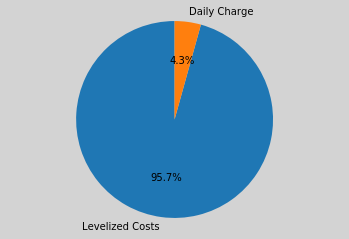

ERROR:ga_logger:panel values: (92.00007419039076, 91.58789507924878, 260.5830384651964, 55.242373774012876, 1.6253535397134435, 1.3662964626560283, 0.2240098506524535, 0.20590857784805178, 0.20699315895304587)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 55.2
                                           and a gcr of 0.224


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0061194896698 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 92
                                           a tilt of 1.6
                                           and a gcr of 0.206


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.771636962890625 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 261
                                           a tilt of 1.4
                                           and a gcr of 0.207


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.739675760269165 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 123.94]


ERROR:ga_logger:Cost: 6253.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


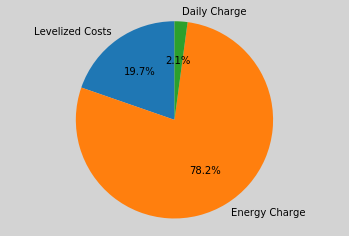

ERROR:ga_logger:panel values: (91.51718340625825, 95.37165176913813, 90.646597502939, 1.098467991041008, 52.814077313594154, 55.70672874030832, 0.23184144150700728, 0.8986499195082305, 0.20718307105482564)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 1.1
                                           and a gcr of 0.232


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.0239098072052 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 52.8
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8945748805999756 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 55.7
                                           and a gcr of 0.207


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.89935302734375 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [12.431, 489.893, 0.0]


ERROR:ga_logger:Cost: 5122.24


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


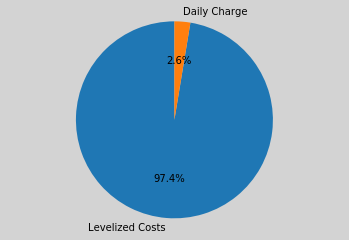

ERROR:ga_logger:panel values: (91.14722599746315, 264.25611484854596, 90.03963097727686, 55.867095961874725, 55.718062050744166, 55.49704252847072, 0.20419967037929737, 0.2337495068293096, 0.22521117535787372)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 55.9
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9497411251068115 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 55.7
                                           and a gcr of 0.234


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.922440528869629 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 55.5
                                           and a gcr of 0.225


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.909480571746826 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [0.0, 139.96, 0.0]


ERROR:ga_logger:Cost: 6605.9


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


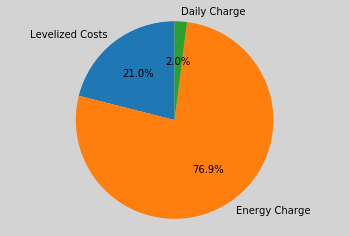

ERROR:ga_logger:panel values: (201.3048393777949, 181.37846820205795, 113.3204172161615, 51.45229693838775, 2.849876796985966, 40.82407596145326, 0.7829019108224016, 0.6545027952723034, 0.3586745119112872)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 201
                                           a tilt of 51.5
                                           and a gcr of 0.783


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.875072717666626 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 181
                                           a tilt of 2.8
                                           and a gcr of 0.655


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7773215770721436 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 113
                                           a tilt of 40.8
                                           and a gcr of 0.359


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.900364637374878 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 328.095, 0.0]


ERROR:ga_logger:Cost: 3391.76


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


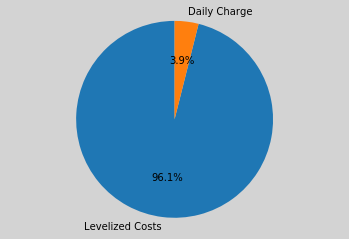

ERROR:ga_logger:panel values: (201.2997556244071, 126.3995936725699, 113.38557897814276, 51.31725060511854, 20.979918904448187, 23.506439880530777, 0.8517004619034909, 0.647707693408284, 0.36211332087125636)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 201
                                           a tilt of 51.3
                                           and a gcr of 0.852


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.962684392929077 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 126
                                           a tilt of 21.0
                                           and a gcr of 0.648


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8711955547332764 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 113
                                           a tilt of 23.5
                                           and a gcr of 0.362


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.896477699279785 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 323.164, 0.0]


ERROR:ga_logger:Cost: 3342.78


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (134.78502010496624, 134.54520019775364, 133.33471022717487, 16.736814564967837, 19.06416624565935, 42.13560559844633, 0.7012485599052796, 0.4235673217320942, 0.3839108376567053)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 16.7
                                           and a gcr of 0.701


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8842732906341553 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 19.1
                                           and a gcr of 0.424


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8705191612243652 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 133
                                           a tilt of 42.1
                                           and a gcr of 0.384


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8799660205841064 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [153.783, 160.728, 0.0]


ERROR:ga_logger:Cost: 3256.84


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (96.3849661916721, 263.67804609808036, 262.64286206803365, 1.005400208767905, 1.239009360203295, 55.59668261298458, 0.21676047134779963, 0.20523058573296732, 0.2036016472877325)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 96
                                           a tilt of 1.0
                                           and a gcr of 0.217


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.096381902694702 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 1.2
                                           and a gcr of 0.205


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7432303428649902 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 263
                                           a tilt of 55.6
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.905898094177246 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 122s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 121.909]


ERROR:ga_logger:Cost: 6732.31


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


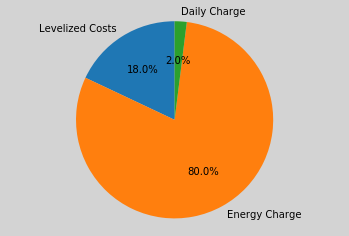

ERROR:ga_logger:panel values: (96.51635354325643, 264.2199593926206, 264.3538430617049, 1.2608824478690726, 1.505421140478668, 55.550576393271314, 0.2089800058745369, 0.8829751750543808, 0.8498902531347958)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 97
                                           a tilt of 1.3
                                           and a gcr of 0.209


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.662264108657837 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 1.5
                                           and a gcr of 0.883


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.584815502166748 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 264
                                           a tilt of 55.6
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8766162395477295 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [59.7168, 276.378, 0.0]


ERROR:ga_logger:Cost: 3471.22


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


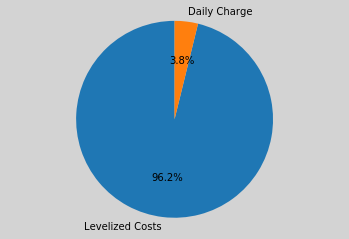

ERROR:ga_logger:panel values: (250.1146936261569, 259.316364311578, 261.56378960813106, 1.0277349830382572, 1.2377684521153527, 55.83885995601967, 0.20164629395766348, 0.20377167079317712, 0.20725232784414407)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 1.0
                                           and a gcr of 0.202


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.067786455154419 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 259
                                           a tilt of 1.2
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.856236219406128 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 262
                                           a tilt of 55.8
                                           and a gcr of 0.207


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9214165210723877 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 124.095]


ERROR:ga_logger:Cost: 6700.61


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


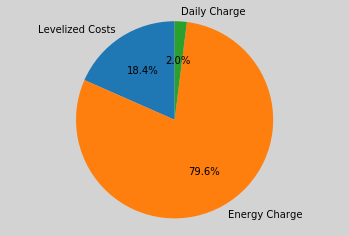

ERROR:ga_logger:panel values: (90.30003442941869, 263.57165436213944, 264.9026092051329, 1.0346250980564882, 9.160037844967519, 55.53417861216443, 0.20363123185849663, 0.20080146697315832, 0.20084577920898836)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.1143429279327393 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 9.2
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9281301498413086 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 55.5
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0592970848083496 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 69s


ERROR:ga_logger:panel relevance: [121.927, 0.0, 0.0]


ERROR:ga_logger:Cost: 6279.49


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


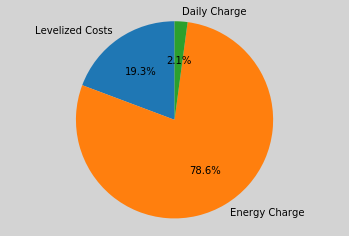

ERROR:ga_logger:panel values: (90.12218907050826, 264.71748215733265, 264.86649496049654, 1.044470548642939, 18.231126742399965, 55.644723166315565, 0.20838602336453926, 0.20153040163363384, 0.20672664207913427)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.208


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.04080867767334 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 18.2
                                           and a gcr of 0.202


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9346437454223633 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 55.6
                                           and a gcr of 0.207


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.938462495803833 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 69s


ERROR:ga_logger:panel relevance: [124.774, 0.0, 0.0]


ERROR:ga_logger:Cost: 6242.11


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


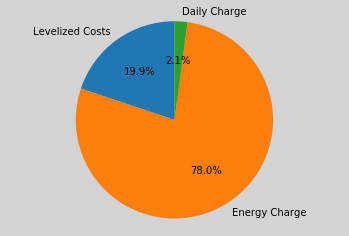

ERROR:ga_logger:panel values: (90.00000000000534, 264.9299294943628, 264.9999999999911, 1.000000000005559, 12.375444750746404, 55.6790464089449, 0.20000000000007886, 0.2000000000000569, 0.20000000000005858)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.100440263748169 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 12.4
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.159280776977539 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 55.7
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9220383167266846 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [119.752, 0.0, 0.0]


ERROR:ga_logger:Cost: 6308.33


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


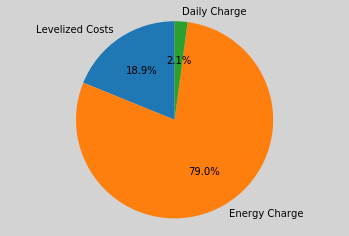

ERROR:ga_logger:panel values: (90.1387563040518, 102.54352292106071, 263.4809646345767, 1.1283228524033664, 55.919760128496215, 13.60829216403218, 0.21722319636013632, 0.20355089881297714, 0.23011731198970262)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.1
                                           and a gcr of 0.217


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.03947114944458 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 103
                                           a tilt of 55.9
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.908944606781006 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 263
                                           a tilt of 13.6
                                           and a gcr of 0.230


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.945836067199707 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 137.785]


ERROR:ga_logger:Cost: 6099.09


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


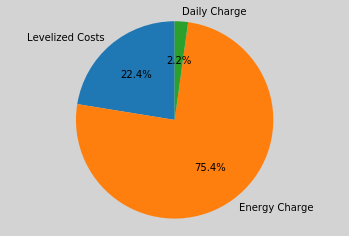

ERROR:ga_logger:panel values: (91.76985942274557, 131.70023226786248, 263.65328095626467, 2.2235889170554017, 13.359333134633776, 54.789463677260976, 0.2766016199594297, 0.2077517068433782, 0.8788422015530633)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 2.2
                                           and a gcr of 0.277


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.855430841445923 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 132
                                           a tilt of 13.4
                                           and a gcr of 0.208


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8971452713012695 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 264
                                           a tilt of 54.8
                                           and a gcr of 0.879


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8926446437835693 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [7.09934, 0.0, 503.66]


ERROR:ga_logger:Cost: 5206.02


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


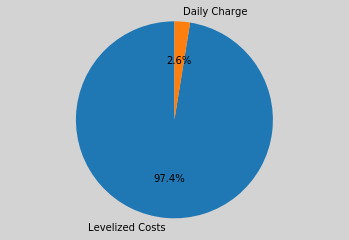

ERROR:ga_logger:panel values: (90.33250550178838, 117.95124053162293, 264.07998610176594, 16.470767389341226, 12.917654281116574, 55.56427975152986, 0.21734354467881128, 0.8381992752432632, 0.2057523001200386)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 16.5
                                           and a gcr of 0.217


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.913937568664551 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 118
                                           a tilt of 12.9
                                           and a gcr of 0.838


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.875804901123047 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 264
                                           a tilt of 55.6
                                           and a gcr of 0.206


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0799851417541504 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 335.31, 0.0]


ERROR:ga_logger:Cost: 3463.43


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


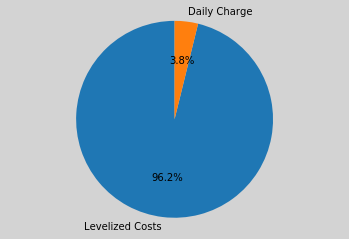

ERROR:ga_logger:panel values: (90.16021725160469, 235.01013481033067, 264.82616987706274, 9.596008106562168, 18.231292130210797, 46.754906422423105, 0.3188957165721341, 0.20248663163560957, 0.20420808742461136)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 9.6
                                           and a gcr of 0.319


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.93864107131958 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 18.2
                                           and a gcr of 0.202


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1895358562469482 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 46.8
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.95914888381958 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [190.943, 0.0, 0.0]


ERROR:ga_logger:Cost: 5369.39


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


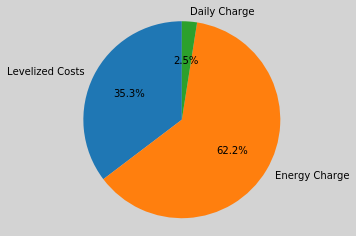

ERROR:ga_logger:panel values: (90.006661929202, 264.8568190543016, 263.8995703778442, 1.0745857423059972, 16.667052965185054, 55.90866071933479, 0.20065198335637835, 0.20279065708189098, 0.21190078300813156)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.1
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.0793964862823486 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 16.7
                                           and a gcr of 0.203


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9364817142486572 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 264
                                           a tilt of 55.9
                                           and a gcr of 0.212


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.940492630004883 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 69s


ERROR:ga_logger:panel relevance: [120.143, 0.0, 0.0]


ERROR:ga_logger:Cost: 6302.93


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (90.00000000002775, 264.99999999996635, 264.9999999998754, 1.0000000000056615, 9.37230856937942, 55.99999999998984, 0.2000000000000872, 0.20000000000048562, 0.2000000000005552)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.0888864994049072 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 9.4
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.04921555519104 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9737534523010254 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [119.752, 0.0, 0.0]


ERROR:ga_logger:Cost: 6308.33


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (90.28868671196324, 263.3210620370707, 264.5863122344114, 1.0009070244610803, 9.165772029262524, 55.59157063481026, 0.20364893464696193, 0.2, 0.20006709259857558)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.109661817550659 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 263
                                           a tilt of 9.2
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9790244102478027 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 55.6
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9027657508850098 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [121.937, 0.0, 0.0]


ERROR:ga_logger:Cost: 6279.49


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (90.29488813625801, 263.55951103148857, 264.8553967360697, 1.2219246980787934, 9.16065776216858, 55.536949936057034, 0.2036319595556983, 0.2, 0.2007413298738732)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.2
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.624713182449341 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 9.2
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.534806251525879 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 55.5
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.925302028656006 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [0.0, 119.752, 0.0]


ERROR:ga_logger:Cost: 6317.92


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (90.27986418822495, 263.57789061143546, 264.90129392277106, 1.0, 9.159748054193354, 55.531050113006465, 0.20365206978275344, 0.20095789876237297, 0.20086983285336935)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.087618350982666 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 9.2
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7628188133239746 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 55.5
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.965871810913086 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [121.939, 0.0, 0.0]


ERROR:ga_logger:Cost: 6279.47


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (90.0, 263.62736319346016, 264.7565689199474, 1.0487487974145837, 9.157599220672445, 55.4972725901308, 0.20392881700830484, 0.20085833761467045, 0.20090521390345326)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.1145997047424316 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 9.2
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9541797637939453 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 55.5
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.913116455078125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 69s


ERROR:ga_logger:panel relevance: [122.105, 0.0, 0.0]


ERROR:ga_logger:Cost: 6277.23


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (90.21686698064661, 263.46967291505115, 265.0, 1.0179007438680883, 9.160495145088428, 55.52907084236563, 0.20348811921542048, 0.2004210222819927, 0.20113198541342728)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.203


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.1347813606262207 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 263
                                           a tilt of 9.2
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9606802463531494 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 55.5
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9161319732666016 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [121.841, 0.0, 0.0]


ERROR:ga_logger:Cost: 6280.72


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


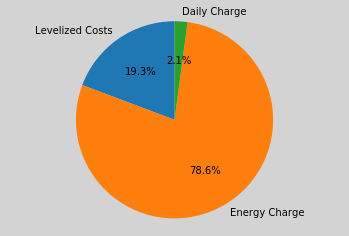

ERROR:ga_logger:panel values: (90.28928800981721, 264.23083288744385, 264.2514414784167, 2.4416910592404286, 55.704146042792246, 51.07661911267777, 0.8962899469354071, 0.22006865172981097, 0.8203533034242372)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 2.4
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.886138677597046 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 55.7
                                           and a gcr of 0.220


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9897267818450928 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 264
                                           a tilt of 51.1
                                           and a gcr of 0.820


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.903693199157715 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [336.406, 0.0, 0.0]


ERROR:ga_logger:Cost: 3474.31


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (90.77435483688389, 185.3688347059049, 263.3347084984618, 3.1417227697039842, 1.9440834482489346, 1.4110492051775838, 0.8981616241835868, 0.24246629439032918, 0.2200936197376342)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 3.1
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8848390579223633 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 1.9
                                           and a gcr of 0.242


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.743612289428711 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 263
                                           a tilt of 1.4
                                           and a gcr of 0.220


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7028727531433105 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [260.729, 74.7934, 0.0]


ERROR:ga_logger:Cost: 3465.54


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


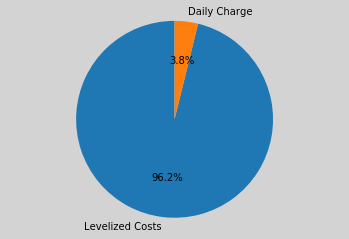

ERROR:ga_logger:panel values: (95.16066425001328, 90.32890142097452, 90.83527966439776, 55.251192517423384, 55.4110515040383, 1.2868433751581778, 0.21001527777592066, 0.8882375675400531, 0.2232194672285641)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 55.3
                                           and a gcr of 0.210


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.048150062561035 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 55.4
                                           and a gcr of 0.888


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8791983127593994 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 1.3
                                           and a gcr of 0.223


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7808187007904053 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [0.0, 531.843, 0.0]


ERROR:ga_logger:Cost: 5539.3


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


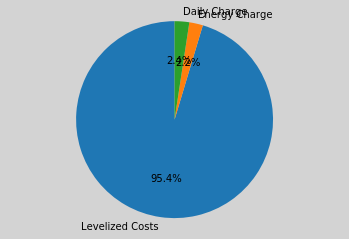

ERROR:ga_logger:panel values: (90.64755845742543, 234.9289653662117, 236.33168254852106, 1.0440560216348125, 18.217467983524905, 55.83396627705459, 0.31893259486333964, 0.20657701864070516, 0.31622057083938687)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 1.0
                                           and a gcr of 0.319


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.178476095199585 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 18.2
                                           and a gcr of 0.207


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9628961086273193 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 236
                                           a tilt of 55.8
                                           and a gcr of 0.316


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.969590902328491 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [190.965, 0.0, 0.0]


ERROR:ga_logger:Cost: 5371.7


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


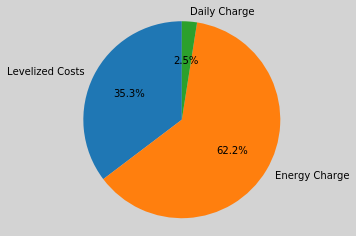

ERROR:ga_logger:panel values: (90.02078383528865, 235.5060198126683, 262.606813139554, 1.0021927577209289, 17.841759739230543, 46.6716757974827, 0.3147955602600242, 0.31515074530061504, 0.20290121667752462)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.315


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.178234100341797 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 236
                                           a tilt of 17.8
                                           and a gcr of 0.315


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3801612854003906 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 263
                                           a tilt of 46.7
                                           and a gcr of 0.203


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9727418422698975 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 188.7, 0.0]


ERROR:ga_logger:Cost: 5180.32


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (90.00000000025302, 264.99999999936233, 90.0000000005553, 1.0000000000298723, 1.000000000199073, 55.999999999430436, 0.2000000000091776, 0.20000000000224033, 0.2000000000010923)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.1817286014556885 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.0341596603393555 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9213883876800537 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [119.752, 0.0, 0.0]


ERROR:ga_logger:Cost: 6308.33


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (91.8002588725681, 103.48042902492617, 90.8077645157747, 53.844996417648375, 55.66825490776433, 55.93607204569878, 0.4881778755421403, 0.8525277391878558, 0.8730229604104893)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 53.8
                                           and a gcr of 0.488


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.295038938522339 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 103
                                           a tilt of 55.7
                                           and a gcr of 0.853


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.884707450866699 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 55.9
                                           and a gcr of 0.873


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.908628463745117 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [47.0634, 428.272, 0.0]


ERROR:ga_logger:Cost: 4854.18


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


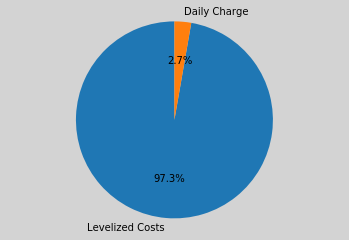

ERROR:ga_logger:panel values: (92.5422648715849, 103.00683265167126, 260.56788560993243, 54.135422659167915, 55.69853049803277, 21.33549395133485, 0.8568248557938027, 0.21183211276793354, 0.21122284612243836)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 93
                                           a tilt of 54.1
                                           and a gcr of 0.857


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.088231086730957 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 103
                                           a tilt of 55.7
                                           and a gcr of 0.212


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9195477962493896 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 261
                                           a tilt of 21.3
                                           and a gcr of 0.211


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.954155445098877 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [513.034, 0.0, 0.0]


ERROR:ga_logger:Cost: 5269.0


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (262.27745368295064, 90.16831360098446, 148.63933389512442, 54.47331461092437, 1.078702175367893, 4.5349941068527, 0.20935939678867166, 0.8994007676292186, 0.8879191722467872)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 54.5
                                           and a gcr of 0.209


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2387850284576416 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 1.1
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.0261619091033936 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 149
                                           a tilt of 4.5
                                           and a gcr of 0.888


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1537516117095947 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 327.766]


ERROR:ga_logger:Cost: 3388.5


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


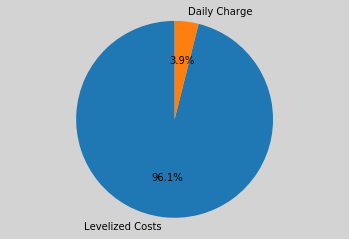

ERROR:ga_logger:panel values: (90.85349410689234, 237.2385230674164, 236.84867411372906, 1.0340063004896176, 1.4644103659429093, 46.521018020858605, 0.3186701610565931, 0.20251116187607282, 0.3148170038538709)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 1.0
                                           and a gcr of 0.319


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.2305407524108887 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 237
                                           a tilt of 1.5
                                           and a gcr of 0.203


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7438244819641113 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 237
                                           a tilt of 46.5
                                           and a gcr of 0.315


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9036920070648193 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [190.807, 0.0, 0.0]


ERROR:ga_logger:Cost: 5373.69


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


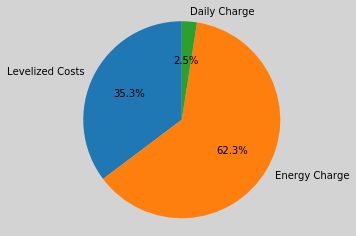

ERROR:ga_logger:panel values: (90.40661500338078, 235.15481496838873, 264.55984195032704, 1.066229320452053, 17.900388387043442, 47.63219341428309, 0.31854885841698993, 0.20799046932781784, 0.20006310987733822)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.1
                                           and a gcr of 0.319


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.248352527618408 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 17.9
                                           and a gcr of 0.208


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0138492584228516 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 47.6
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.931070327758789 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 124.537, 0.0]


ERROR:ga_logger:Cost: 6091.98


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (90.00000000003055, 264.99999999998084, 264.9999999990141, 1.0000000000060902, 55.99999999997748, 55.99999999997486, 0.8999999999993527, 0.8999999999999, 0.20000000000006188)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.2392306327819824 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9103314876556396 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9313511848449707 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 118s


ERROR:ga_logger:panel relevance: [335.991, 0.0, 0.0]


ERROR:ga_logger:Cost: 3470.19


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


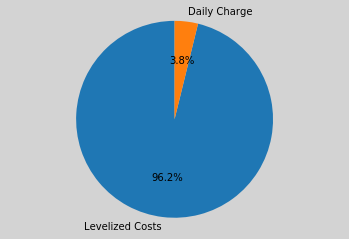

ERROR:ga_logger:panel values: (91.1930868787714, 264.1684826852627, 91.59139088865743, 37.167528693221975, 55.68975325257088, 2.9879516593015945, 0.7140434675593306, 0.34968558747575407, 0.21297868286872068)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 37.2
                                           and a gcr of 0.714


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.16215443611145 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 55.7
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9289283752441406 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 92
                                           a tilt of 3.0
                                           and a gcr of 0.213


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8199715614318848 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [406.413, 0.0, 6.30208]


ERROR:ga_logger:Cost: 4232.23


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (264.39811078185016, 261.14607263033446, 98.55959781120751, 27.841630777903354, 55.59311860348493, 55.54666670245903, 0.2538606559029498, 0.8722285973439823, 0.21843805595734617)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 27.8
                                           and a gcr of 0.254


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1385457515716553 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 261
                                           a tilt of 55.6
                                           and a gcr of 0.872


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.897406578063965 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 99
                                           a tilt of 55.5
                                           and a gcr of 0.218


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9240875244140625 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [7.73054, 495.696, 0.0]


ERROR:ga_logger:Cost: 5133.19


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (90.10593249811015, 203.72123544227728, 234.13166599868302, 31.52423122296348, 54.38236222630302, 34.6085360814276, 0.4614687754105716, 0.44514280579237575, 0.21498980670147327)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 31.5
                                           and a gcr of 0.461


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1629788875579834 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 204
                                           a tilt of 54.4
                                           and a gcr of 0.445


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.897716522216797 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 234
                                           a tilt of 34.6
                                           and a gcr of 0.215


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.923978328704834 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 266.534, 0.0]


ERROR:ga_logger:Cost: 4110.42


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (90.05120684505418, 261.40517136473363, 236.85091546196202, 1.0129764605617688, 1.3541837601424431, 55.883015963500654, 0.31867714446649553, 0.31593787801698636, 0.21097408064102513)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.319


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.281280040740967 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 261
                                           a tilt of 1.4
                                           and a gcr of 0.316


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6754281520843506 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 237
                                           a tilt of 55.9
                                           and a gcr of 0.211


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.89990496635437 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 126.323]


ERROR:ga_logger:Cost: 6337.45


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (90.03753345897901, 260.1659268094553, 264.0028861663361, 1.0063206441441568, 1.6221028145446947, 55.15449505667797, 0.20022862718861273, 0.30870837333511925, 0.203660693548406)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3101694583892822 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 1.6
                                           and a gcr of 0.309


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.754923105239868 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 264
                                           a tilt of 55.2
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.041219711303711 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 121.944]


ERROR:ga_logger:Cost: 6745.13


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


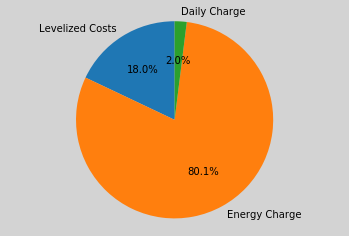

ERROR:ga_logger:panel values: (264.9999999999828, 90.00000000001381, 264.9999999999348, 1.0000000000011107, 1.000000000007281, 55.99999999997853, 0.20000000000015, 0.8999999999998956, 0.20000000000015558)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3238167762756348 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.032461643218994 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9354536533355713 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 335.991, 0.0]


ERROR:ga_logger:Cost: 3470.19


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


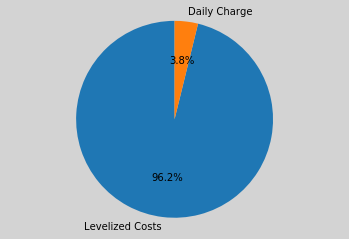

ERROR:ga_logger:panel values: (90.19175626141936, 263.59747887628623, 265.0, 1.0, 9.168646525224581, 55.61388995584505, 0.20595605634132205, 0.20080181761695914, 0.20037681713752967)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.206


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3475234508514404 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 9.2
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.929993152618408 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 55.6
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9343249797821045 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 69s


ERROR:ga_logger:panel relevance: [123.319, 0.0, 0.0]


ERROR:ga_logger:Cost: 6261.37


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (90.15703483158, 263.577333936263, 264.9832072789006, 1.0, 9.168138896929849, 55.60879114399764, 0.20575720096205877, 0.2016073856864274, 0.20030969164494394)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.206


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3292760848999023 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 9.2
                                           and a gcr of 0.202


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9715943336486816 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 55.6
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3255772590637207 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 69s


ERROR:ga_logger:panel relevance: [123.2, 0.0, 0.0]


ERROR:ga_logger:Cost: 6262.95


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


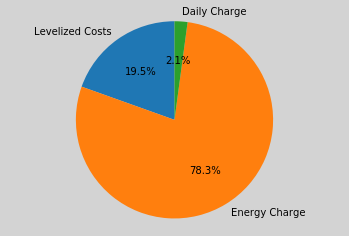

ERROR:ga_logger:panel values: (90.17761773538354, 263.54849099159446, 265.0, 1.0495636508661537, 9.170087207998234, 55.625061851893186, 0.20600286367675222, 0.20074726413629723, 0.20026951660169062)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.206


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3665592670440674 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 9.2
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5194294452667236 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 55.6
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9423296451568604 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [123.347, 0.0, 0.0]


ERROR:ga_logger:Cost: 6260.83


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (261.29547754083865, 93.3510036861289, 264.72469497429984, 21.196191749831385, 2.171847763980884, 55.71963172187811, 0.8730213702867946, 0.2174127650186347, 0.2118025670903878)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 261
                                           a tilt of 21.2
                                           and a gcr of 0.873


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3019680976867676 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 93
                                           a tilt of 2.2
                                           and a gcr of 0.217


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7943742275238037 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 55.7
                                           and a gcr of 0.212


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.967167377471924 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [319.398, 50.6373, 0.0]


ERROR:ga_logger:Cost: 3808.32


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


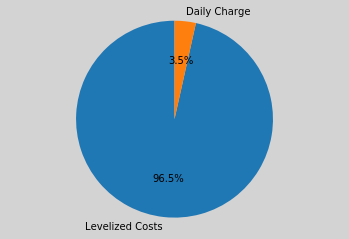

ERROR:ga_logger:panel values: (264.7622225618331, 98.11931490812702, 98.47024594940784, 4.70113183712429, 1.4182291232597346, 1.80299090030569, 0.2168487002043799, 0.20328555031147302, 0.8367546905381149)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 4.7
                                           and a gcr of 0.217


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.31365966796875 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 98
                                           a tilt of 1.4
                                           and a gcr of 0.203


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.785996198654175 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 98
                                           a tilt of 1.8
                                           and a gcr of 0.837


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7807576656341553 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 335.048]


ERROR:ga_logger:Cost: 3460.82


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (263.11514974950876, 252.7406934121595, 261.375054425096, 53.41662891116902, 1.4685770367001796, 2.438782536727862, 0.8695092592036888, 0.8671179267401876, 0.890082730190837)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 263
                                           a tilt of 53.4
                                           and a gcr of 0.870


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2197463512420654 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 253
                                           a tilt of 1.5
                                           and a gcr of 0.867


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5304067134857178 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 261
                                           a tilt of 2.4
                                           and a gcr of 0.890


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6979360580444336 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 335.38, 0.0]


ERROR:ga_logger:Cost: 3464.12


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


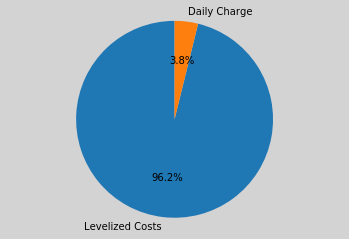

ERROR:ga_logger:panel values: (90.2897491360422, 235.56463748406807, 264.7542895199407, 1.030041625123202, 1.0088190516160431, 55.935044049890735, 0.3197669368424592, 0.24107194208980787, 0.20014512142948704)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.320


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.403704881668091 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 236
                                           a tilt of 1.0
                                           and a gcr of 0.241


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.0432586669921875 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 55.9
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9161622524261475 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 119.839]


ERROR:ga_logger:Cost: 6787.45


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


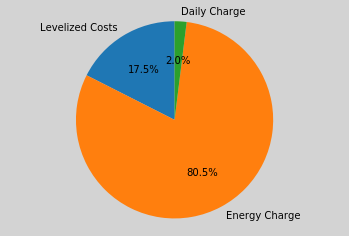

ERROR:ga_logger:panel values: (90.45287649327493, 264.83474594857205, 264.2261109580003, 1.0065946188428192, 17.422508039272582, 55.743301493785545, 0.32101330505927866, 0.20186316480556782, 0.20671809268920255)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.321


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4082815647125244 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 17.4
                                           and a gcr of 0.202


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.44973087310791 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 264
                                           a tilt of 55.7
                                           and a gcr of 0.207


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9217467308044434 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 120.868, 0.0]


ERROR:ga_logger:Cost: 6344.3


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


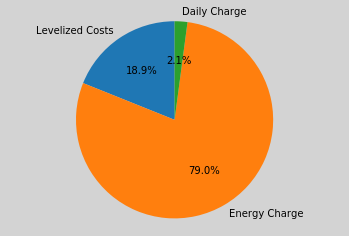

ERROR:ga_logger:panel values: (90.00000000000175, 211.63297601215618, 264.9999999999855, 1.0000000000004525, 55.99999999999297, 55.99999999999855, 0.20000000000003365, 0.20000000000002469, 0.20000000000001586)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4390382766723633 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 212
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9346799850463867 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9802865982055664 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 69s


ERROR:ga_logger:panel relevance: [119.752, 0.0, 0.0]


ERROR:ga_logger:Cost: 6308.33


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


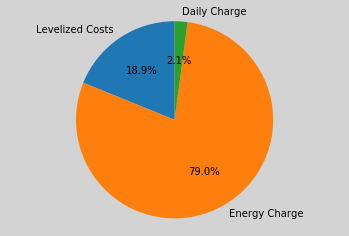

ERROR:ga_logger:panel values: (90.55229950286089, 260.5369722761477, 92.84891911927811, 53.49151656839328, 55.45935734643927, 55.98365788526478, 0.8904859033087815, 0.33219888008619125, 0.8203278363504962)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 53.5
                                           and a gcr of 0.890


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.285663366317749 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 261
                                           a tilt of 55.5
                                           and a gcr of 0.332


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.924168348312378 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 93
                                           a tilt of 56.0
                                           and a gcr of 0.820


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.915956497192383 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 491.181]


ERROR:ga_logger:Cost: 5362.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


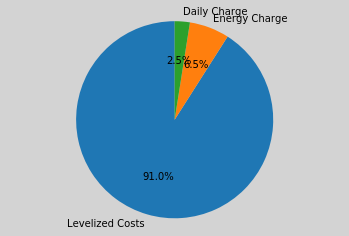

ERROR:ga_logger:panel values: (262.29794502257175, 93.47808410456301, 263.1733864248059, 18.66660539252418, 1.1470560548579314, 2.216213241212108, 0.24624091288109404, 0.46665808229931965, 0.3317730414416258)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 18.7
                                           and a gcr of 0.246


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.373307466506958 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 93
                                           a tilt of 1.1
                                           and a gcr of 0.467


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3803741931915283 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 263
                                           a tilt of 2.2
                                           and a gcr of 0.332


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8533926010131836 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 198.653]


ERROR:ga_logger:Cost: 5273.66


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (91.769863806293, 96.44327371663184, 123.9919779390956, 12.37687958657909, 1.7640319303961123, 2.6731346906234466, 0.2562618552061856, 0.23357576470268354, 0.20430651667352537)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 12.4
                                           and a gcr of 0.256


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5456793308258057 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 96
                                           a tilt of 1.8
                                           and a gcr of 0.234


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8628485202789307 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 124
                                           a tilt of 2.7
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8777148723602295 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [153.44, 0.0, 0.0]


ERROR:ga_logger:Cost: 5861.55


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (90.08308596899504, 234.79318446035265, 236.42115180718477, 4.13527122061596, 18.008846379614337, 55.131211850001755, 0.3211998693588726, 0.3055852300690134, 0.20618243933902322)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 4.1
                                           and a gcr of 0.321


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3714540004730225 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 18.0
                                           and a gcr of 0.306


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0392184257507324 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 236
                                           a tilt of 55.1
                                           and a gcr of 0.206


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9756581783294678 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 182.973, 0.0]


ERROR:ga_logger:Cost: 5254.18


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


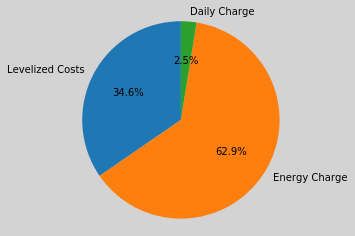

ERROR:ga_logger:panel values: (90.25584907425699, 235.1364018563575, 238.21185022770723, 1.0603805547447942, 18.051956875368298, 55.84290776412273, 0.21275921979060688, 0.20107946974871024, 0.2016209768954139)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.1
                                           and a gcr of 0.213


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.540121555328369 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 18.1
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9834446907043457 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 238
                                           a tilt of 55.8
                                           and a gcr of 0.202


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0788466930389404 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [127.392, 0.0, 0.0]


ERROR:ga_logger:Cost: 6207.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


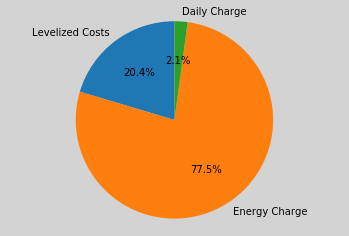

ERROR:ga_logger:panel values: (90.00000000001297, 90.00000000005926, 264.99999999992787, 1.000000000002521, 1.0000000000318658, 55.999999999985526, 0.20000000000046111, 0.20000000000014534, 0.20000000000011048)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5674901008605957 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.1069443225860596 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.102602481842041 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 119.752]


ERROR:ga_logger:Cost: 6792.9


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (262.2587513014498, 262.24777152806195, 136.7083831894995, 3.298531300304804, 1.5317532843558963, 55.76122987918483, 0.8963599210956434, 0.23529223119221984, 0.891276234973978)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 3.3
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.27323579788208 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 262
                                           a tilt of 1.5
                                           and a gcr of 0.235


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.881680965423584 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 137
                                           a tilt of 55.8
                                           and a gcr of 0.891


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.977379083633423 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [265.743, 71.1271, 0.0]


ERROR:ga_logger:Cost: 3478.92


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


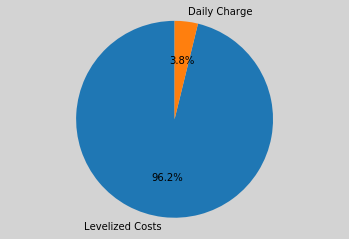

ERROR:ga_logger:panel values: (91.16064821326394, 98.68887236533905, 90.78916374136907, 14.865286193696964, 55.51604136404218, 51.80297517526363, 0.21481693146020386, 0.20012925051812352, 0.6513881142439908)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 14.9
                                           and a gcr of 0.215


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4502618312835693 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 99
                                           a tilt of 55.5
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.053605794906616 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 51.8
                                           and a gcr of 0.651


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0008366107940674 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 69s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 390.026]


ERROR:ga_logger:Cost: 5217.23


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (93.48299965111072, 94.95265598991459, 264.48321238945005, 51.35153815798332, 1.934842716723976, 1.8147144670620443, 0.5430381582181457, 0.8448805904595409, 0.7781229573707156)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 93
                                           a tilt of 51.4
                                           and a gcr of 0.543


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.469430446624756 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 1.9
                                           and a gcr of 0.845


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8794422149658203 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 264
                                           a tilt of 1.8
                                           and a gcr of 0.778


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.768674850463867 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 335.368, 0.0]


ERROR:ga_logger:Cost: 3464.0


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


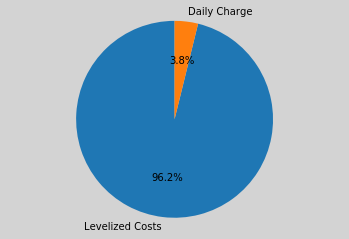

ERROR:ga_logger:panel values: (90.23334438041147, 206.53774887495896, 211.24946302094946, 5.657024040355987, 27.120547710179384, 46.80801495385875, 0.32612907885897924, 0.20649500006024837, 0.22542077288259993)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 5.7
                                           and a gcr of 0.326


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.455214262008667 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 207
                                           a tilt of 27.1
                                           and a gcr of 0.206


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.060222625732422 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 211
                                           a tilt of 46.8
                                           and a gcr of 0.225


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.052440643310547 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [195.274, 0.0, 0.0]


ERROR:ga_logger:Cost: 5302.12


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


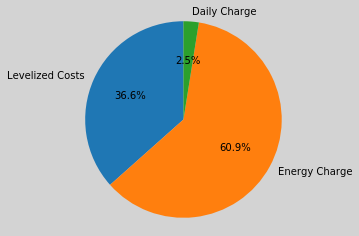

ERROR:ga_logger:panel values: (90.01868095811356, 208.0588714558382, 260.1383209029849, 1.1195330591970347, 26.385381269128164, 55.998434827294716, 0.2091909309220945, 0.3165287083942199, 0.20347393928163637)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.1
                                           and a gcr of 0.209


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6161820888519287 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 208
                                           a tilt of 26.4
                                           and a gcr of 0.317


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.058027505874634 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 56.0
                                           and a gcr of 0.203


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0116350650787354 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [125.256, 0.0, 0.0]


ERROR:ga_logger:Cost: 6235.55


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (90.0000000000309, 264.9999999998459, 264.999999999508, 1.0000000000073692, 55.999999999837996, 55.999999999963336, 0.20000000000096377, 0.20000000000111634, 0.20000000000033727)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.642230272293091 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.035936117172241 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9814229011535645 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 69s


ERROR:ga_logger:panel relevance: [119.752, 0.0, 0.0]


ERROR:ga_logger:Cost: 6308.33


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


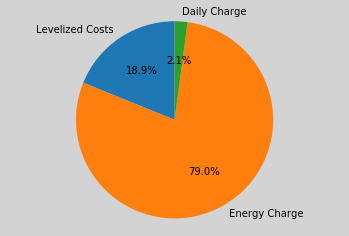

ERROR:ga_logger:panel values: (121.36778082813308, 208.21001217304635, 259.99006839315894, 1.2144906208160948, 26.419318405943862, 55.95094836824941, 0.2, 0.3179322296415806, 0.20244026461721193)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 121
                                           a tilt of 1.2
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.13789701461792 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 208
                                           a tilt of 26.4
                                           and a gcr of 0.318


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.975074291229248 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 56.0
                                           and a gcr of 0.202


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9756827354431152 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [0.0, 190.366, 0.0]


ERROR:ga_logger:Cost: 4854.27


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (90.0117704569237, 208.05956613266764, 260.13758278366095, 1.1197409829565004, 26.385594335929888, 56.0, 0.20918162765395115, 0.31653058868085804, 0.2034533844004814)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.1
                                           and a gcr of 0.209


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.655517816543579 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 208
                                           a tilt of 26.4
                                           and a gcr of 0.317


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.002671003341675 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 56.0
                                           and a gcr of 0.203


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.011479139328003 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 62s


ERROR:ga_logger:panel relevance: [125.25, 0.0, 0.0]


ERROR:ga_logger:Cost: 6235.63


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


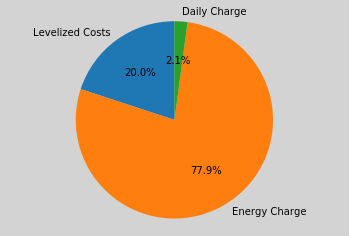

ERROR:ga_logger:panel values: (103.84578508898055, 208.0457454542854, 260.15741239748536, 1.1363328408502915, 26.37617744084328, 55.807091593938885, 0.20637881013554513, 0.31690776530627646, 0.2052958435118716)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 104
                                           a tilt of 1.1
                                           and a gcr of 0.206


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.662482261657715 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 208
                                           a tilt of 26.4
                                           and a gcr of 0.317


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9777121543884277 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 55.8
                                           and a gcr of 0.205


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.984161853790283 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [123.572, 0.0, 0.0]


ERROR:ga_logger:Cost: 6250.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


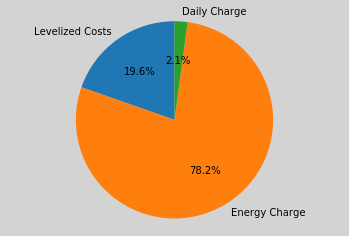

ERROR:ga_logger:panel values: (90.0188109110992, 208.05960506993407, 260.137544201405, 1.1197638786028639, 26.385603470476344, 56.0, 0.2091794858190411, 0.31653091890718704, 0.2034530096945687)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.1
                                           and a gcr of 0.209


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6891186237335205 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 208
                                           a tilt of 26.4
                                           and a gcr of 0.317


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.051647424697876 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 56.0
                                           and a gcr of 0.203


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2016797065734863 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [125.249, 0.0, 0.0]


ERROR:ga_logger:Cost: 6235.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


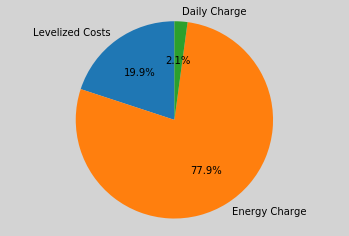

ERROR:ga_logger:panel values: (90.0, 207.93742500109394, 260.252942377313, 1.1088043700319439, 26.40661520980715, 55.96987985676256, 0.20839335955456578, 0.3154463587451576, 0.20422280059079156)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.1
                                           and a gcr of 0.208


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.689591646194458 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 208
                                           a tilt of 26.4
                                           and a gcr of 0.315


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.077594041824341 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 56.0
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0053462982177734 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [124.778, 0.0, 0.0]


ERROR:ga_logger:Cost: 6241.88


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


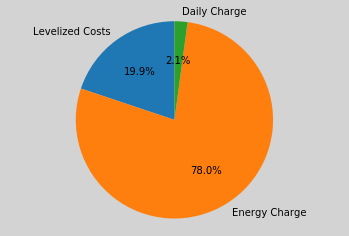

ERROR:ga_logger:panel values: (232.03468967342567, 90.297320482798, 262.164904563185, 2.7592920609718736, 55.25003749023017, 55.74637340216508, 0.24249555920763186, 0.20117739341738106, 0.20400389820930986)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 232
                                           a tilt of 2.8
                                           and a gcr of 0.242


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4642627239227295 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 55.3
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0400311946868896 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 262
                                           a tilt of 55.7
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0436508655548096 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [145.197, 0.0, 0.0]


ERROR:ga_logger:Cost: 5933.8


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


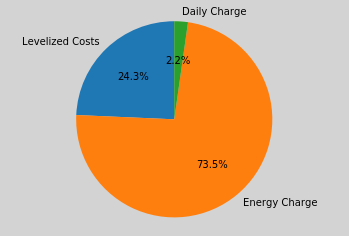

ERROR:ga_logger:panel values: (194.00725360342403, 259.00792234990234, 257.87484785844686, 3.452966844836883, 54.67639056549004, 1.8949496368500824, 0.8912395634642325, 0.8857807848528576, 0.20062601396819887)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 194
                                           a tilt of 3.5
                                           and a gcr of 0.891


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.486553430557251 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 259
                                           a tilt of 54.7
                                           and a gcr of 0.886


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.044362783432007 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 258
                                           a tilt of 1.9
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9097135066986084 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [328.071, 0.0, 0.0]


ERROR:ga_logger:Cost: 3391.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


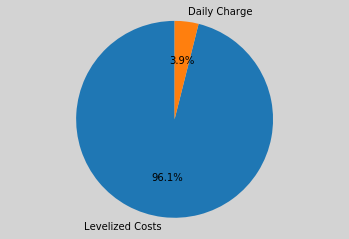

ERROR:ga_logger:panel values: (191.1841752006012, 260.5736096327847, 101.25611451468399, 1.9813774997083713, 54.406370031570944, 54.98125175863876, 0.2199587067820029, 0.2010828272571674, 0.21345322050315765)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 191
                                           a tilt of 2.0
                                           and a gcr of 0.220


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4954769611358643 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 261
                                           a tilt of 54.4
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0947978496551514 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 101
                                           a tilt of 55.0
                                           and a gcr of 0.213


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.051826238632202 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [131.703, 0.0, 0.0]


ERROR:ga_logger:Cost: 6103.43


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


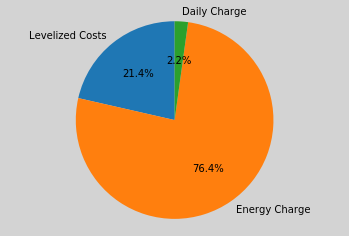

ERROR:ga_logger:panel values: (118.69174554278375, 234.9960239439545, 239.37816669535405, 10.078772958710994, 35.31534005284039, 47.70990499586426, 0.202563684040904, 0.20391609814763, 0.20543878362299878)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 119
                                           a tilt of 10.1
                                           and a gcr of 0.203


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.729454517364502 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 35.3
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0487546920776367 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 239
                                           a tilt of 47.7
                                           and a gcr of 0.205


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0330309867858887 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [0.0, 122.097, 0.0]


ERROR:ga_logger:Cost: 6137.65


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


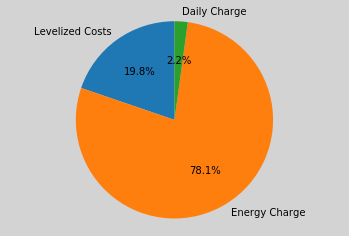

ERROR:ga_logger:panel values: (118.75396884514217, 233.05619283700602, 233.49453414629997, 1.2791569792544952, 17.52933568509407, 48.784132412584206, 0.31737028586262805, 0.22509465576297766, 0.21831618969424924)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 119
                                           a tilt of 1.3
                                           and a gcr of 0.317


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.55212140083313 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 233
                                           a tilt of 17.5
                                           and a gcr of 0.225


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.086986541748047 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 233
                                           a tilt of 48.8
                                           and a gcr of 0.218


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.060206413269043 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 134.778, 0.0]


ERROR:ga_logger:Cost: 5933.59


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (157.71095572683862, 234.0331118677221, 264.9999999999578, 1.0000000000262532, 55.999999999996035, 51.895788743721795, 0.3128396773241422, 0.20000000000007329, 0.2851645230108533)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 158
                                           a tilt of 1.0
                                           and a gcr of 0.313


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.832770824432373 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 234
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1679632663726807 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 51.9
                                           and a gcr of 0.285


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3989288806915283 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 170.746]


ERROR:ga_logger:Cost: 6281.07


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


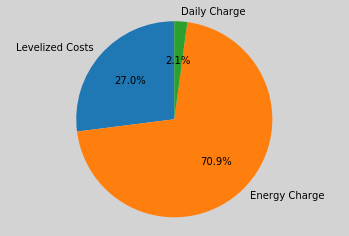

ERROR:ga_logger:panel values: (193.94352252339723, 97.23787322265746, 249.90939262929268, 55.70118672848637, 1.6262207433682683, 52.56160570829898, 0.21571449086217795, 0.4253373102368204, 0.22089669542676887)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 194
                                           a tilt of 55.7
                                           and a gcr of 0.216


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.689208745956421 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 97
                                           a tilt of 1.6
                                           and a gcr of 0.425


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9171524047851562 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 52.6
                                           and a gcr of 0.221


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.067265033721924 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 254.676, 0.0]


ERROR:ga_logger:Cost: 4520.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (172.84275796979438, 261.1652329436996, 256.12110192202283, 19.609030834069806, 1.7879709015889391, 55.30994850133323, 0.8355079230301159, 0.8962847071847677, 0.20409226903422442)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 173
                                           a tilt of 19.6
                                           and a gcr of 0.836


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9573051929473877 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 261
                                           a tilt of 1.8
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8684921264648438 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 256
                                           a tilt of 55.3
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.120392322540283 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [314.28, 0.0, 0.0]


ERROR:ga_logger:Cost: 3254.55


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


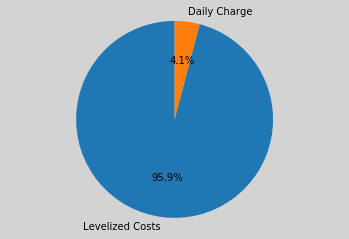

ERROR:ga_logger:panel values: (172.21989536582305, 101.57660643969014, 97.64908356333486, 22.495678809662905, 2.26289043274212, 55.794451803377065, 0.20561367163648792, 0.8952097325473598, 0.2134072243359911)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 172
                                           a tilt of 22.5
                                           and a gcr of 0.206


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7204296588897705 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 102
                                           a tilt of 2.3
                                           and a gcr of 0.895


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9468977451324463 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 98
                                           a tilt of 55.8
                                           and a gcr of 0.213


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.133713483810425 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [62.5267, 263.786, 0.0]


ERROR:ga_logger:Cost: 3374.06


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (118.4132973458556, 180.9968760307151, 231.32584029471644, 10.142935986186414, 18.570461954898278, 55.991055749388295, 0.24251771594311464, 0.20109115265186497, 0.200969038641934)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 118
                                           a tilt of 10.1
                                           and a gcr of 0.243


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6861517429351807 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 181
                                           a tilt of 18.6
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3151538372039795 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 231
                                           a tilt of 56.0
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1212170124053955 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [145.21, 0.0, 0.0]


ERROR:ga_logger:Cost: 5835.08


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


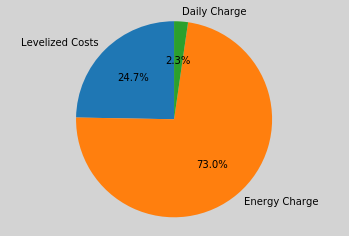

ERROR:ga_logger:panel values: (116.5545309519535, 236.5099942479068, 262.65041187318354, 2.555482442693366, 17.917524319149287, 54.05887739420672, 0.24356176007943026, 0.2855829799334932, 0.2344145573380399)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 117
                                           a tilt of 2.6
                                           and a gcr of 0.244


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.613433837890625 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 237
                                           a tilt of 17.9
                                           and a gcr of 0.286


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3741543292999268 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 263
                                           a tilt of 54.1
                                           and a gcr of 0.234


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.073451042175293 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [0.0, 170.996, 0.0]


ERROR:ga_logger:Cost: 5440.16


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


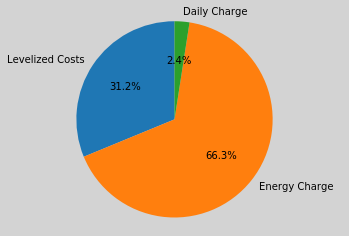

ERROR:ga_logger:panel values: (94.46863430428762, 208.1916052442493, 260.0326968005435, 1.1224366555762455, 26.3482709949026, 55.86301049319248, 0.20888883616565718, 0.31559663422607004, 0.2046226523868582)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 94
                                           a tilt of 1.1
                                           and a gcr of 0.209


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8471169471740723 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 208
                                           a tilt of 26.3
                                           and a gcr of 0.316


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0848143100738525 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 55.9
                                           and a gcr of 0.205


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.17195987701416 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [125.075, 0.0, 0.0]


ERROR:ga_logger:Cost: 6235.74


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


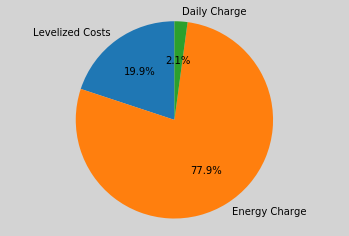

ERROR:ga_logger:panel values: (140.9724989864048, 164.9176467583534, 264.7853873739619, 1.4327850535941429, 55.94548539376466, 54.04802317996952, 0.20573223250126332, 0.8959553684928767, 0.762271029460478)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 141
                                           a tilt of 1.4
                                           and a gcr of 0.206


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.678420305252075 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 55.9
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0277726650238037 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 54.0
                                           and a gcr of 0.762


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0540835857391357 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [54.1917, 300.461, 0.0]


ERROR:ga_logger:Cost: 3655.54


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


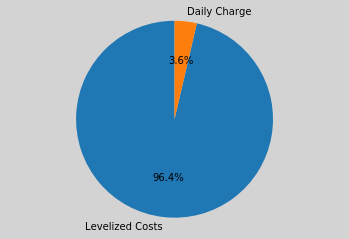

ERROR:ga_logger:panel values: (146.86345875934873, 96.17875850722288, 97.05806071761602, 55.85736975215632, 33.13497595007367, 1.0432238596821033, 0.20161796331234141, 0.20285162934488635, 0.8898962518345264)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 147
                                           a tilt of 55.9
                                           and a gcr of 0.202


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.809843063354492 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 96
                                           a tilt of 33.1
                                           and a gcr of 0.203


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1262574195861816 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 97
                                           a tilt of 1.0
                                           and a gcr of 0.890


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.2691025733947754 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [58.917, 0.0, 272.789]


ERROR:ga_logger:Cost: 3427.63


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (147.7122368028376, 262.80729685881226, 91.2957382183371, 20.971371385582227, 6.053458210216203, 2.901256428033014, 0.8893169910719416, 0.20446310794115205, 0.25832490125075813)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 148
                                           a tilt of 21.0
                                           and a gcr of 0.889


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.757939100265503 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 263
                                           a tilt of 6.1
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3328919410705566 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 2.9
                                           and a gcr of 0.258


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.917271852493286 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [329.616, 0.0, 0.0]


ERROR:ga_logger:Cost: 3406.87


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


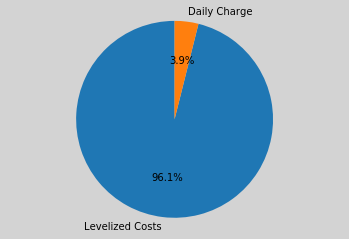

ERROR:ga_logger:panel values: (116.33129398977319, 207.76742459738387, 263.3806353497564, 10.737144665036826, 24.649612305952346, 55.354331260430904, 0.2003630009554797, 0.40019907349235073, 0.34407178419098805)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 116
                                           a tilt of 10.7
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.757955551147461 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 208
                                           a tilt of 24.6
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.029029369354248 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 263
                                           a tilt of 55.4
                                           and a gcr of 0.344


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.052751064300537 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 239.624, 0.0]


ERROR:ga_logger:Cost: 4102.08


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (112.72928019092649, 259.487239432985, 251.41596432175, 6.354575073008329, 13.495623363542197, 45.027254662368684, 0.3585371451910949, 0.37234042027955816, 0.2012140246511719)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 113
                                           a tilt of 6.4
                                           and a gcr of 0.359


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.113044023513794 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 259
                                           a tilt of 13.5
                                           and a gcr of 0.372


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.143671989440918 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 251
                                           a tilt of 45.0
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.117868185043335 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [214.678, 0.0, 0.0]


ERROR:ga_logger:Cost: 4944.96


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


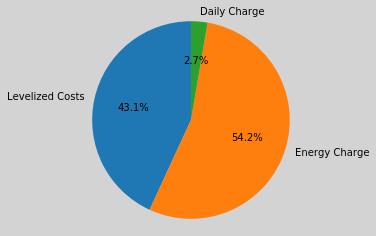

ERROR:ga_logger:panel values: (167.37059047786164, 90.00000000002838, 264.9999999999794, 1.0000000000173068, 1.0000000000047249, 54.01899209712187, 0.20000000000007018, 0.20000000000027943, 0.3398070660015182)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.915402412414551 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.1525299549102783 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 54.0
                                           and a gcr of 0.340


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.073312997817993 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 108s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 203.463]


ERROR:ga_logger:Cost: 6081.22


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


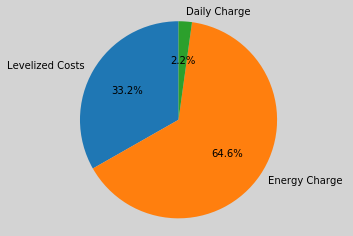

ERROR:ga_logger:panel values: (113.24332908197846, 237.6841571821198, 259.92805298152587, 10.84249808138922, 19.838946152224118, 50.16617202911323, 0.2, 0.2771162598180169, 0.28030314514460086)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 113
                                           a tilt of 10.8
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.788386583328247 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 238
                                           a tilt of 19.8
                                           and a gcr of 0.277


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0328562259674072 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 50.2
                                           and a gcr of 0.280


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0870063304901123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 165.927, 0.0]


ERROR:ga_logger:Cost: 5515.44


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


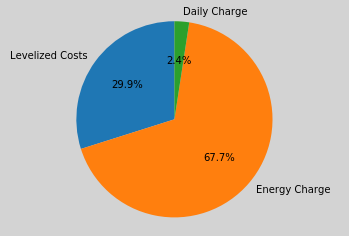

ERROR:ga_logger:panel values: (115.54609984005108, 235.05457092112133, 263.8306153605001, 1.3540704648564632, 18.696689618121628, 56.0, 0.2602918568379052, 0.2687164191619413, 0.2908103586621478)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 116
                                           a tilt of 1.4
                                           and a gcr of 0.260


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7060186862945557 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 18.7
                                           and a gcr of 0.269


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.672697067260742 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 264
                                           a tilt of 56.0
                                           and a gcr of 0.291


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0774383544921875 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 160.897, 0.0]


ERROR:ga_logger:Cost: 5567.81


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


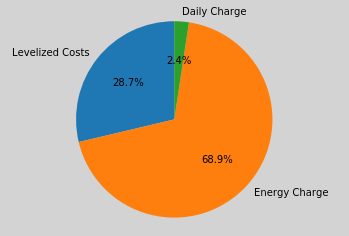

ERROR:ga_logger:panel values: (115.52137083914722, 236.90235990795705, 261.772163340374, 5.194624609053219, 18.514263312626674, 52.79943181777134, 0.2295393946966176, 0.2831461267814535, 0.24812427248245145)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 116
                                           a tilt of 5.2
                                           and a gcr of 0.230


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8424558639526367 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 237
                                           a tilt of 18.5
                                           and a gcr of 0.283


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1931567192077637 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 262
                                           a tilt of 52.8
                                           and a gcr of 0.248


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.064275026321411 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 169.537, 0.0]


ERROR:ga_logger:Cost: 5461.62


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


ERROR:ga_logger:panel values: (116.29640035662183, 236.04084187128277, 263.0595743467836, 2.049460077077507, 18.12730586345369, 54.72235065645225, 0.2494425473110163, 0.28050428786467213, 0.25111064059216653)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 116
                                           a tilt of 2.0
                                           and a gcr of 0.249


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7335972785949707 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 236
                                           a tilt of 18.1
                                           and a gcr of 0.281


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1029467582702637 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 263
                                           a tilt of 54.7
                                           and a gcr of 0.251


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0791351795196533 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 167.955, 0.0]


ERROR:ga_logger:Cost: 5478.26


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


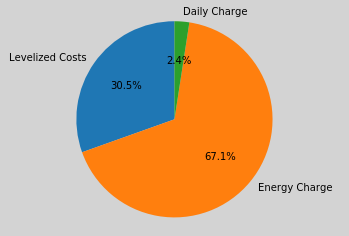

ERROR:ga_logger:panel values: (116.30860674597122, 236.62220712501218, 262.4205064911615, 3.2223452251943656, 18.057553240903204, 53.726638075134446, 0.2399126577082384, 0.28515123128963005, 0.23723760597348661)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 116
                                           a tilt of 3.2
                                           and a gcr of 0.240


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7922017574310303 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 237
                                           a tilt of 18.1
                                           and a gcr of 0.285


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.572887659072876 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 262
                                           a tilt of 53.7
                                           and a gcr of 0.237


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.068755865097046 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 170.738, 0.0]


ERROR:ga_logger:Cost: 5444.14


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


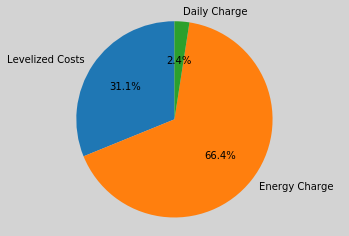

ERROR:ga_logger:panel values: (116.53400257570154, 236.38980906168987, 262.77479864581244, 2.3449556281777486, 17.94307528615606, 54.25456398525914, 0.24540063111290839, 0.2845259665268902, 0.2376814275192712)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 117
                                           a tilt of 2.3
                                           and a gcr of 0.245


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.842838764190674 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 236
                                           a tilt of 17.9
                                           and a gcr of 0.285


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.623396873474121 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 263
                                           a tilt of 54.3
                                           and a gcr of 0.238


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0802061557769775 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 170.363, 0.0]


ERROR:ga_logger:Cost: 5447.97


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


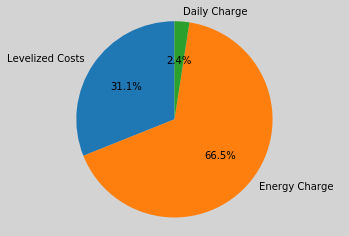

ERROR:ga_logger:panel values: (116.5029833960721, 236.54720010693194, 262.58705516156886, 2.7233810795774502, 17.94541110718736, 53.965636626285075, 0.24257045521013992, 0.2856003324329696, 0.23468608761200516)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 117
                                           a tilt of 2.7
                                           and a gcr of 0.243


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7629263401031494 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 237
                                           a tilt of 17.9
                                           and a gcr of 0.286


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.036282539367676 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 263
                                           a tilt of 54.0
                                           and a gcr of 0.235


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0664889812469482 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 171.007, 0.0]


ERROR:ga_logger:Cost: 5440.2


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


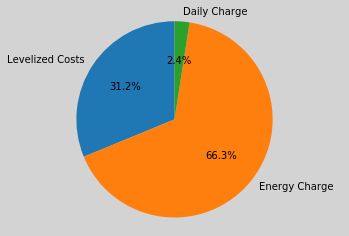

ERROR:ga_logger:panel values: (116.56165429829542, 236.48197394230957, 262.68452292653166, 2.4852710482097713, 17.91611869602974, 54.111218191941525, 0.24407728540613544, 0.28540027858483086, 0.2349123462167051)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 117
                                           a tilt of 2.5
                                           and a gcr of 0.244


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7925469875335693 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 236
                                           a tilt of 17.9
                                           and a gcr of 0.285


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.17050838470459 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 263
                                           a tilt of 54.1
                                           and a gcr of 0.235


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.142955780029297 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 170.887, 0.0]


ERROR:ga_logger:Cost: 5441.47


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


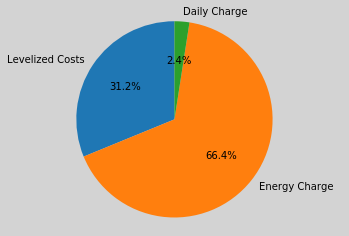

ERROR:ga_logger:panel values: (246.7404256312073, 262.50212663959496, 264.44576849794316, 55.0269764991197, 54.89049638171595, 1.0035792208558494, 0.21172851431148423, 0.20003352932359214, 0.22422184639635634)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 247
                                           a tilt of 55.0
                                           and a gcr of 0.212


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.908942937850952 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 263
                                           a tilt of 54.9
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0944771766662598 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 264
                                           a tilt of 1.0
                                           and a gcr of 0.224


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.151712417602539 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [126.775, 0.0, 0.0]


ERROR:ga_logger:Cost: 6443.09


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


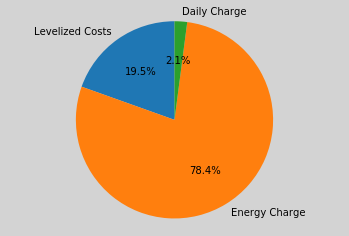

ERROR:optimizer_logger:Finished and stored: {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:Runs_logger:Run nr 2 using opt-method rbf-net with 100 evalautions took: (min)


ERROR:Runs_logger:453.37475558916725


In [29]:
# Bonmin path
BONMIN_PATH = "/home/theochri/projects/def-revins/theochri/Bonmin/bonmin"

# GA
if (opt_method =="ga-20"):
    init_pop=20
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="ga-50"):
    init_pop=50
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="ga-100"):
    init_pop=100
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-net"):
    # implementation of the max_evaluations only works starting from 6 or higher
    # also if you set this max_evalutions to 10 it will stop after 9 evaluations
    # therefore I have added 1 to the max_evaluations. 
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE-NET", bonmin_path=BONMIN_PATH, rand_seed =int(run_i) )
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-cost"):
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE", bonmin_path=BONMIN_PATH, rand_seed =int(run_i))
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-cost-true"):
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE", bonmin_path=BONMIN_PATH, rand_seed =int(run_i))
    pvoptimizer.processGA(ga_fina)

# runtime in seconds
endtime=time.time()-t1
mintime=endtime/60
lrun.error("Run nr {} using opt-method {} with {} evalautions took: (min)".format(run_i,opt_method,number_of_opt_evaluations))
lrun.error(mintime)